# 01 - Tax Burden by State

Calculate the total effective tax burden on individuals per state, including both state and federal payroll taxes.

**Taxes included:**
- State income tax
- Property tax
- Sales tax
- State fees
- Social Security (FICA) — 6.2% employee share
- Medicare — 1.45% employee share
- FMLA / State Paid Family & Medical Leave (varies by state)

**Data sources:**
- Census Bureau State Tax Collections
- Bureau of Economic Analysis (personal income by state)
- SSA (Social Security rates)
- DOL / state agencies (PFML programs)

**Output:** `tax_burden.csv`, `tax_burden.json`

In [1]:
import sys, os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

# allow imports from src/
sys.path.insert(0, str(Path("..").resolve()))
from src.data_utils import download_file, load_census_stc, fetch_bea_personal_income

load_dotenv(Path("../.env"))

RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Federal payroll tax rates (2024, flat across all states)
SOCIAL_SECURITY_RATE = 0.062  # employee share, up to wage base
MEDICARE_RATE = 0.0145        # employee share, no cap

# States with Paid Family & Medical Leave programs and their employee contribution rates
# Source: individual state PFML program documentation
STATE_PFML_RATES = {
    "CA": 0.009,   # SDI + PFL
    "CO": 0.0045,  # FAMLI
    "CT": 0.005,   # CT Paid Leave
    "DE": 0.005,   # Healthy Delaware Families Act (2026)
    "MA": 0.00318, # PFML
    "MD": 0.0025,  # FAMLI (2026)
    "MN": 0.005,   # PFML (2026)
    "NJ": 0.006,   # TDI + FLI
    "NY": 0.00455, # PFL + DBL
    "OR": 0.006,   # PFMLI
    "RI": 0.011,   # TCI
    "WA": 0.0058,  # PFML
}

In [3]:
# Download Census State Tax Collections (FY2024, transposed Excel)
STC_URL = "https://www2.census.gov/programs-surveys/stc/tables/2024/FY2024-STC-Category-Table-Transposed.xlsx"
stc_path = download_file(STC_URL, RAW_DIR / "stc_2024.xlsx")

Saved to ../data/raw/stc_2024.xlsx (9,901 bytes)


In [4]:
# Parse & clean the STC data
stc = load_census_stc(stc_path)
print(f"{len(stc)} rows, {stc['state'].nunique()} states")
stc.head(10)

400 rows, 50 states


,state,state_name,category,amount
0,AL,Alabama,Total Taxes,16895681.0
1,AL,Alabama,Property Taxes,620698.0
2,AL,Alabama,Sales and Gross Receipts Taxes,8106236.0
3,AL,Alabama,License Taxes,612540.0
4,AL,Alabama,Income Taxes,7463209.0
5,AL,Alabama,Other Taxes,92998.0
6,AL,Alabama,Footnotes,NaN
7,AL,Alabama,X - Not available.,NaN
8,AK,Alaska,Total Taxes,1985846.0
9,AK,Alaska,Property Taxes,130855.0


In [5]:
# Extract total state tax collections per state
# Look for the "Total Taxes" (or similar) category row
total_label = stc[stc["category"].str.contains("Total", case=False, na=False)]["category"].unique()
print("Categories containing 'Total':", total_label)

# Use the first match that looks like overall total
total_cat = [c for c in total_label if "total tax" in c.lower() or c.strip().lower() == "total"]
if total_cat:
    total_cat = total_cat[0]
else:
    total_cat = total_label[0]
print(f"Using category: '{total_cat}'")

state_taxes = (
    stc[stc["category"] == total_cat][["state", "state_name", "amount"]]
    .rename(columns={"amount": "total_state_taxes"})
    .reset_index(drop=True)
)
state_taxes.head()

Categories containing 'Total': ['Total Taxes']
Using category: 'Total Taxes'


,state,state_name,total_state_taxes
0,AL,Alabama,16895681.0
1,AK,Alaska,1985846.0
2,AZ,Arizona,23595616.0
3,AR,Arkansas,12674290.0
4,CA,California,265550679.0


In [6]:
# Fetch personal income by state from BEA API
BEA_API_KEY = os.environ.get("BEA_API_KEY", "")
if not BEA_API_KEY:
    raise EnvironmentError(
        "BEA_API_KEY not found. Create a .env file in the project root with:\n"
        "  BEA_API_KEY=your-key-here\n"
        "Register at https://apps.bea.gov/api/signup/"
    )

income = fetch_bea_personal_income(BEA_API_KEY, year="2023")
print(f"{len(income)} states with personal income data")
income.head()

49 states with personal income data


,state,state_name,personal_income
0,AL,Alabama,279484.6
1,AZ,Arizona,471040.2
2,AR,Arkansas,173568.3
3,CA,California,3182779.3
4,CO,Colorado,473104.6


In [7]:
# Calculate tax burden per state
burden = state_taxes.merge(income[["state", "personal_income"]], on="state", how="inner")

# State tax burden as a fraction of personal income
# Census STC amounts are in thousands of dollars; BEA SAINC1 Line 1 is also in thousands
burden["state_tax_rate"] = burden["total_state_taxes"] / burden["personal_income"]

# Federal payroll taxes (same for every state)
burden["ss_rate"] = SOCIAL_SECURITY_RATE
burden["medicare_rate"] = MEDICARE_RATE

# State PFML (0 for states without a program)
burden["pfml_rate"] = burden["state"].map(STATE_PFML_RATES).fillna(0.0)

# Total effective burden
burden["federal_payroll_rate"] = burden["ss_rate"] + burden["medicare_rate"]
burden["total_burden"] = (
    burden["state_tax_rate"]
    + burden["federal_payroll_rate"]
    + burden["pfml_rate"]
)

# Sanity check
print(f"States: {len(burden)}")
print(f"State tax rate range: {burden['state_tax_rate'].min():.3%} – {burden['state_tax_rate'].max():.3%}")
print(f"Total burden range:   {burden['total_burden'].min():.3%} – {burden['total_burden'].max():.3%}")
burden.sort_values("total_burden", ascending=False).head(10)

States: 48
State tax rate range: 3226.580% – 11641.202%
Total burden range:   3234.230% – 11648.852%


,state,state_name,total_state_taxes,personal_income,state_tax_rate,ss_rate,medicare_rate,pfml_rate,federal_payroll_rate,total_burden
28,NM,New Mexico,13694047.0,117634.3,116.412024,0.062,0.0145,0.00000,0.0765,116.488524
42,VT,Vermont,4640749.0,44058.6,105.331286,0.062,0.0145,0.00000,0.0765,105.407786
31,ND,North Dakota,5847708.0,56452.5,103.586343,0.062,0.0145,0.00000,0.0765,103.662843
6,DE,Delaware,6534362.0,66943.8,97.609667,0.062,0.0145,0.00500,0.0765,97.691167
20,MN,Minnesota,35666979.0,418091.0,85.309129,0.062,0.0145,0.00500,0.0765,85.390629
3,CA,California,265550679.0,3182779.3,83.433582,0.062,0.0145,0.00900,0.0765,83.519082
45,WV,West Virginia,6983118.0,93771.0,74.469911,0.062,0.0145,0.00000,0.0765,74.546411
29,NY,New York,119727037.0,1617130.9,74.036701,0.062,0.0145,0.00455,0.0765,74.117751
10,IL,Illinois,66920244.0,907225.7,73.763611,0.062,0.0145,0.00000,0.0765,73.840111
2,AR,Arkansas,12674290.0,173568.3,73.021917,0.062,0.0145,0.00000,0.0765,73.098417


In [8]:
# Export to CSV and JSON
export_cols = [
    "state", "state_name", "total_state_taxes", "personal_income",
    "state_tax_rate", "ss_rate", "medicare_rate", "pfml_rate",
    "federal_payroll_rate", "total_burden",
]
out = burden[export_cols].sort_values("state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "tax_burden.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "tax_burden.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

Wrote ../data/processed/tax_burden.csv
Wrote ../docs/charts/data/tax_burden.json


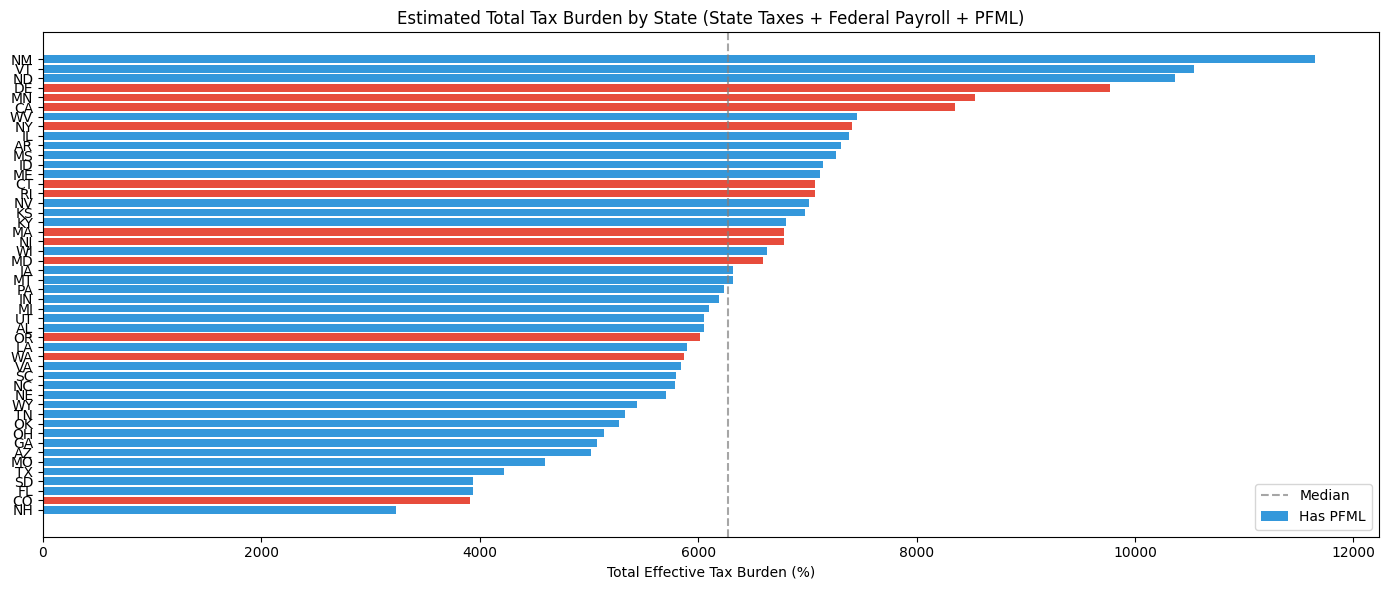

In [9]:
# Quick visualization — total tax burden by state
fig, ax = plt.subplots(figsize=(14, 6))
plot_data = out.sort_values("total_burden", ascending=True)

colors = ["#e74c3c" if s in STATE_PFML_RATES else "#3498db" for s in plot_data["state"]]

ax.barh(plot_data["state"], plot_data["total_burden"] * 100, color=colors)
ax.set_xlabel("Total Effective Tax Burden (%)")
ax.set_title("Estimated Total Tax Burden by State (State Taxes + Federal Payroll + PFML)")
ax.axvline(x=plot_data["total_burden"].median() * 100, color="gray", linestyle="--", alpha=0.7, label="Median")
ax.legend(["Median", "Has PFML", "No PFML"])
plt.tight_layout()
plt.show()